In [62]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, 'C:/Users/chuck/OneDrive/Desktop/Honors/solarEL/solarel')
from image_processor import split_module_to_cells
import time

%matplotlib inline

# Load image

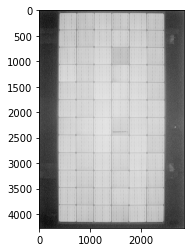

In [63]:
import os, random
image_dir = random.choice(os.listdir("module_images"))
img = cv2.imread("C:/Users/chuck/OneDrive/Desktop/IV_curve_prediction/Images/M0060/LRP504033180800402204_IMG_8693.JPG")
# img = cv2.imread('module_images/160101038551_IMG_8985.JPG')
cv2.imwrite("report_images/module_image.png", img)
plt.imshow(img)

# Process image

In [64]:
model_path_cells = (
    "C:/Users/chuck/OneDrive/Desktop/Honors/models/resnet_backbone_512.hdf5"
)
model_path_module = (
    "C:/Users/chuck/OneDrive/Desktop/Honors/models/resnet_PV_module_256.hdf5"
)
folders = [
    "C:/Users/chuck/OneDrive/Desktop/Honors/M0060/M0060",
    "C:/Users/chuck/OneDrive/Desktop/Honors/BT1/BT1",
]
toml_path = "C:/Users/chuck/OneDrive/Desktop/Honors/solarEL/solarel/configs/camera_config.toml"

image, pannel_images, coords = split_module_to_cells(
        model_path_module=model_path_module,
        model_path_cells=model_path_cells,
        image=img,
        toml_path=toml_path,
        show=False,
        both=True
    )


model loading 3.325106382369995
barrel distort 0.04721355438232422
1/1 [==============================] - 1s 769ms/step
module crop 0.9012184143066406
1/1 [==============================] - 0s 357ms/step
module mask 13.027284383773804
houglines 0.05853700637817383
(4176, 2172)
(4173, 2172)


In [65]:
image_cp = np.copy(image)
image_cp = cv2.merge((image_cp, image_cp, image_cp))
image_cp_with_lines = np.copy(image_cp)
# coords.reverse()
# print(coords)
for square in coords:
    print(square)
    polygon = np.array(square, dtype=np.int32)

    # Draw the polygon on the image
    cv2.polylines(image_cp_with_lines, [polygon], isClosed=True, color=(0, 0, 255), thickness=5)

[[1774. 3780.]
 [1776. 4106.]
 [2106. 4104.]
 [2104. 3778.]]
[[1438. 3780.]
 [1440. 4106.]
 [1770. 4104.]
 [1768. 3778.]]
[[1102. 3780.]
 [1104. 4106.]
 [1434. 4104.]
 [1432. 3778.]]
[[ 766. 3780.]
 [ 768. 4106.]
 [1098. 4104.]
 [1096. 3778.]]
[[ 430. 3780.]
 [ 432. 4106.]
 [ 762. 4104.]
 [ 760. 3778.]]
[[  94. 3780.]
 [  96. 4106.]
 [ 426. 4104.]
 [ 424. 3778.]]
[[1774. 3452.]
 [1776. 3770.]
 [2106. 3768.]
 [2104. 3450.]]
[[1438. 3452.]
 [1440. 3770.]
 [1770. 3768.]
 [1768. 3450.]]
[[1102. 3452.]
 [1104. 3770.]
 [1434. 3768.]
 [1432. 3450.]]
[[ 766. 3452.]
 [ 768. 3770.]
 [1098. 3768.]
 [1096. 3450.]]
[[ 430. 3452.]
 [ 432. 3770.]
 [ 762. 3768.]
 [ 760. 3450.]]
[[  94. 3452.]
 [  96. 3770.]
 [ 426. 3768.]
 [ 424. 3450.]]
[[1774. 3124.]
 [1776. 3442.]
 [2106. 3440.]
 [2104. 3122.]]
[[1438. 3124.]
 [1440. 3442.]
 [1770. 3440.]
 [1768. 3122.]]
[[1102. 3124.]
 [1104. 3442.]
 [1434. 3440.]
 [1432. 3122.]]
[[ 766. 3124.]
 [ 768. 3442.]
 [1098. 3440.]
 [1096. 3122.]]
[[ 430. 3124.]
 [ 432. 3

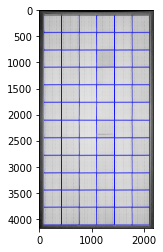

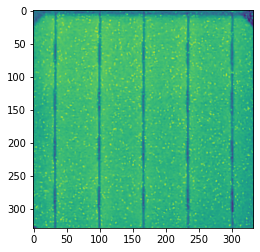

In [66]:
plt.imshow(image_cp_with_lines)
cv2.imwrite('report_images/cell_segmentation.png', image_cp_with_lines)
plt.show()
plt.imshow(pannel_images[0])

In [67]:
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.10.0
Keras version: 2.10.0


In [68]:
from tensorflow import keras

input_shape = (300,300)

good_model_path = "C:/Users/chuck/OneDrive/Desktop/Honors/models/final_models/good_model_Xception.h5"
good_model = keras.models.load_model(good_model_path, compile=False)

crack_model_path = "C:/Users/chuck/OneDrive/Desktop/Honors/models/final_models/crack_model_Xception.h5"
crack_model = keras.models.load_model(crack_model_path, compile=False)

corrosion_model_path = "C:/Users/chuck/OneDrive/Desktop/Honors/models/final_models/corrosion_model_Xception.h5"
corrosion_model = keras.models.load_model(corrosion_model_path, compile=False)


In [69]:
def pre_process_image(image, shape):
    image = cv2.merge((image, image, image))
    return np.array(cv2.resize(image, (shape)))

# Colours

In [70]:
no_fault = (122, 224, 88)
okay = (210, 229, 158)
meh =  (245, 132, 71)
shit = (222, 0, 18)
colours = [shit, meh, okay, no_fault]

# Classify cells in image

In [71]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Set TensorFlow logging level to suppress messages
tf.config.set_visible_devices([], 'GPU')

good = []
corrosion = []
crack = []

for i in range(len(pannel_images)):
    image = pannel_images[i]
    image = pre_process_image(image, input_shape)
    good_pred = np.argmax(good_model.predict(np.expand_dims(image, axis=0)))
    good.append(good_pred)

    if good_pred == 3:
        corrosion.append(None)
        crack.append(None)
        continue
    corrosion_pred = np.argmax(corrosion_model.predict(np.expand_dims(image, axis=0)))
    corrosion.append(corrosion_pred)
    crack_pred = np.argmax(crack_model.predict(np.expand_dims(image, axis=0)))
    crack.append(crack_pred)

1/1 [==============================] - 0s 172ms/step


# Add predictions to image

In [72]:
from image_processor import reproject_image
from image_processor import draw_poly_outline, fill_poly_with_color

def colour_bar(h, w, colors):
    # Create an empty image with the specified dimensions
    image = np.zeros((h, w, 3), dtype=np.uint8)
    
    num_colors = len(colors)
    
    # Calculate the height of each color segment
    segment_height = h // num_colors
    
    for i in range(num_colors):
        start_color = colors[i]
        end_color = colors[i]
        
        # Generate the gradient for the current segment
        for y in range(i * segment_height, (i + 1) * segment_height):
            interpolation_factor = (y - i * segment_height) / segment_height
            
            interpolated_colour = (
                int((1 - interpolation_factor) * start_color[0] + interpolation_factor * end_color[0]),
                int((1 - interpolation_factor) * start_color[1] + interpolation_factor * end_color[1]),
                int((1 - interpolation_factor) * start_color[2] + interpolation_factor * end_color[2])
            )
            
            # Set the pixel color in the image
            image[y, :, :] = interpolated_colour
    
    return image

h,w,c = np.shape(image_cp)
colors = [good, okay, meh, shit]
bar = colour_bar(h, 200, colors)

C:\Users\chuck\AppData\Local\Temp\ipykernel_1780\1041690514.py:33: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  small_patch = mpatches.Patch(color=okay, label='Small Fault', edgecolor='black', linewidth=1)
C:\Users\chuck\AppData\Local\Temp\ipykernel_1780\1041690514.py:34: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  medium_patch = mpatches.Patch(color=meh, label='Medium Fault', edgecolor='black', linewidth=1)
C:\Users\chuck\AppData\Local\Temp\ipykernel_1780\1041690514.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  severe_patch = mpatches.Patch(color=shit, label='Severe Fault', edgecolor='black', linewidth=1)
C:\Users\chuck\AppData\Local\Temp\ipykernel_1780\1041690514.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:

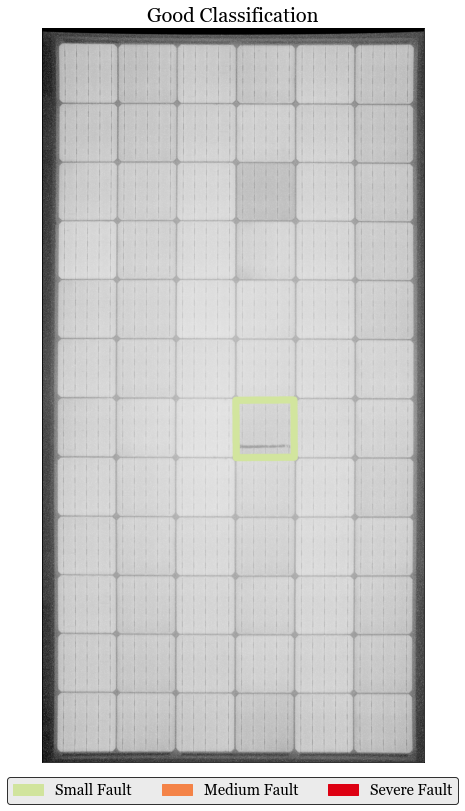

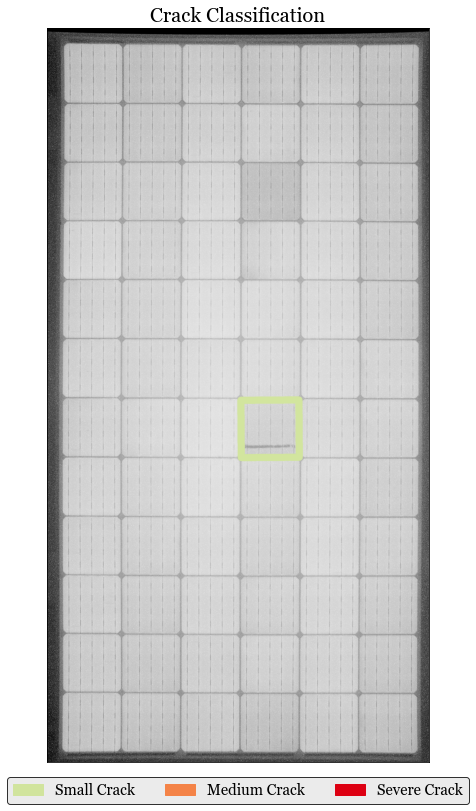

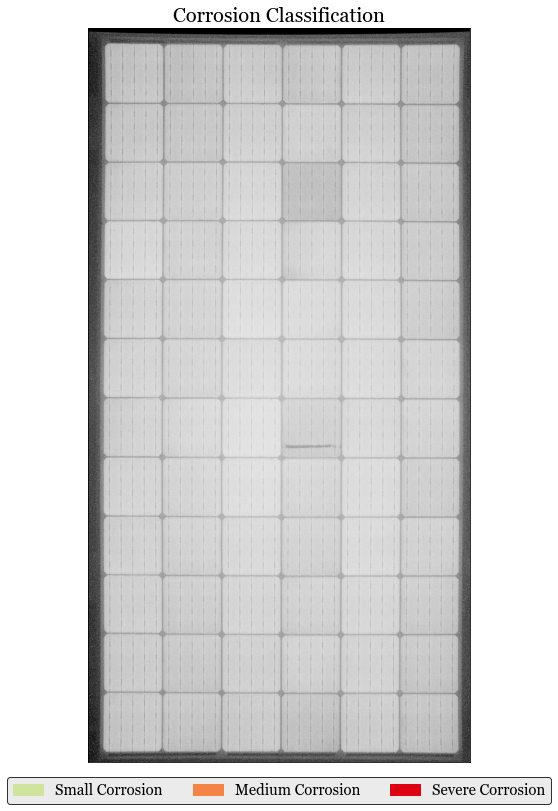

In [73]:
import matplotlib.patches as mpatches

good_image = np.copy(image_cp)
crack_image = np.copy(image_cp)
corrosion_image = np.copy(image_cp)


for i in range(len(pannel_images)):
    if good[i] == 3: continue
    good_image = draw_poly_outline(good_image, coords[i], colours[good[i]], 40)

for i in range(len(pannel_images)):
    if crack[i] is None or crack[i] == 0:
        continue
    crack_image = draw_poly_outline(crack_image, coords[i], colours[3-crack[i]], 40)

for i in range(len(pannel_images)):
    if corrosion[i] is None or corrosion[i] == 0:
        continue
    corrosion_image = draw_poly_outline(corrosion_image, coords[i], colours[3-corrosion[i]], 40)  


fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Good Classification", font='Georgia', fontsize=20)
im = ax.imshow(good_image)
ax.set_xticks([])
ax.set_yticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height* 0.9])
okay = (210/256, 229/256, 158/256)
meh =  (245/256, 132/256, 71/256)
shit = (222/256, 0/256, 18/256)
small_patch = mpatches.Patch(color=okay, label='Small Fault', edgecolor='black', linewidth=1)
medium_patch = mpatches.Patch(color=meh, label='Medium Fault', edgecolor='black', linewidth=1)
severe_patch = mpatches.Patch(color=shit, label='Severe Fault', edgecolor='black', linewidth=1)
legend = ax.legend(handles=[small_patch, medium_patch, severe_patch], loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, ncol=3, prop={'family':'Georgia', 'size':15}, facecolor=(0.9,0.9,0.9))
legend.get_frame().set_edgecolor('black')
fig.show()
fig.savefig("report_images/good.png", dpi='figure')

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Crack Classification", font='Georgia', fontsize=20)
im = ax.imshow(crack_image)
ax.set_xticks([])
ax.set_yticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height* 0.9])
small_patch = mpatches.Patch(color=okay, label='Small Crack', edgecolor='black', linewidth=1)
medium_patch = mpatches.Patch(color=meh, label='Medium Crack', edgecolor='black', linewidth=1)
severe_patch = mpatches.Patch(color=shit, label='Severe Crack', edgecolor='black', linewidth=1)
legend = ax.legend(handles=[small_patch, medium_patch, severe_patch], loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, ncol=3, prop={'family':'Georgia', 'size':15}, facecolor=(0.9,0.9,0.9))
legend.get_frame().set_edgecolor('black')
fig.show()
fig.savefig("report_images/crack.png", dpi='figure')

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Corrosion Classification", font='Georgia', fontsize=20)
im = ax.imshow(corrosion_image)
ax.set_xticks([])
ax.set_yticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height* 0.9])
small_patch = mpatches.Patch(color=okay, label='Small Corrosion', edgecolor='black')
medium_patch = mpatches.Patch(color=meh, label='Medium Corrosion', edgecolor='black')
severe_patch = mpatches.Patch(color=shit, label='Severe Corrosion', edgecolor='black')
legend = ax.legend(handles=[small_patch, medium_patch, severe_patch], loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, ncol=3, prop={'family':'Georgia', 'size':15}, facecolor=(0.9,0.9,0.9))
legend.get_frame().set_edgecolor('black')
fig.show()
fig.savefig("report_images/corrosion.png", dpi='figure')

# Power degradation prediction

In [74]:
iv_model_path = "C:/Users/chuck/OneDrive/Desktop/Honors/models/final_models/iv_small.h5"
iv_model = keras.models.load_model(iv_model_path, compile=False)

In [75]:
power_shape = (300, 550)
def pre_process_image_power(image, shape):
    img = cv2.resize(image, (shape), cv2.INTER_AREA)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_array = np.array(img)/256     # convert to numpy array
    return img_array

In [76]:
power_image = np.copy(image_cp)
print(power_image.shape)
power_image = pre_process_image_power(power_image, power_shape)
print(power_image.shape)
power_degradation = iv_model.predict(np.expand_dims(power_image, 0))[0][0]*0.4+0.6

(4173, 2172, 3)
(550, 300, 3)
(550, 300)
1/1 [==============================] - 0s 149ms/step


# Make PDF

In [77]:
from fpdf import FPDF
import string

title = f'EL image report'


class PDF(FPDF):
    def header(self):
        # font
        self.set_font('Helvetica', 'B', 18)
        # Calculate width of title and position
        title_w = self.get_string_width(title) + 6
        doc_w = self.w
        self.set_x((doc_w - title_w) / 2)
        # Thickness of frame (border)
        self.set_line_width(1)
        # Title
        self.cell(title_w, 10, title, ln=1, align='C')
        # Line break
        self.ln(10)

    # Page footer
    def footer(self):
        # Set position of the footer
        self.set_y(-15)
        # set font
        self.set_font('helvetica', 'I', 8)
        # Set font color grey
        self.set_text_color(169,169,169)
        # Page number
        self.cell(0, 10, f'Page {self.page_no()}', align='C')

    # Adding chapter title to start of each chapter
    def chapter_title(self, ch_num, ch_title, link):
        # Set link location
        self.set_link(link)
        # set font
        self.set_font('Helvetica', '', 16)
        # background color
        chapter_title = f'Chapter {ch_num} : {ch_title}'
        self.cell(0, 5, chapter_title, ln=1)
        # line break
        self.ln()

    def print_chapter(self, ch_num, ch_title, name, link):
        self.add_page()
        self.chapter_title(ch_num, ch_title, link)
        self.chapter_body(name)

# Create a PDF object
pdf = PDF('P', 'mm', 'Letter')

# metadata
pdf.set_title(title)
pdf.set_author('UTAS - CSIRO')


# Set auto page break
pdf.set_auto_page_break(auto = True, margin = 15)

# Add Page
def new_image_page(pdf, image_path):
    pdf.add_page()
    pdf.image('report_images/CSIRO_Logo.png', x = 10, y = 10, w=20, h=20)
    pdf.image('report_images/Utas_Logo.png', x = pdf.w-10-20, y = 10, h=20)
    pdf.set_font('Times', '', 12)
    pdf.cell(0, 10, f'Predicted Power Degradation: {round(power_degradation, 3)}', 0, 0, 'C')

    image = cv2.imread(image_path)
    image_aspect_ratio = image.shape[1]/image.shape[0]
    image_height = pdf.h-100
    image_width = (image_height)*image_aspect_ratio
    print(image_aspect_ratio)
    pdf.image(image_path, x=pdf.w//2-image_width//2, y = 40, h = image_height)
    return pdf

pdf = new_image_page(pdf, 'report_images/module_image.png')
pdf = new_image_page(pdf, 'report_images/cell_segmentation.png')
pdf = new_image_page(pdf, 'report_images/good.png')
pdf = new_image_page(pdf, 'report_images/crack.png')
pdf = new_image_page(pdf, 'report_images/corrosion.png')
empty = ''
pdf.output(f'pdfs/{empty.join(random.choices(string.ascii_lowercase, k=5))}.pdf')

0.6666666666666666
0.5204888569374551
1.0
1.0
1.0


''

In [78]:
import string
print(''.join(random.choices(string.ascii_lowercase, k=5)))

pdhbd


In [79]:
import cv2
img = cv2.imread("report_images/CSIRO_Logo_raw.png", -1)
res = cv2.resize(img, (0,0), fx=0.2, fy=0.2, interpolation = cv2.INTER_AREA)
cv2.imwrite("report_images/CSIRO_Logo.png", res)

True